## GAN

## The structure of GAN
![](./gan.svg)<br>
GAN is composed of two adversarial networks. The generative network is to approximate the distribution of real data while the discriminative network is to send learning signals to the generative model by classfying whether the sample is drawn of the real distribution or is generated.

## The objective of GAN
We denote the generative network as $G$ and the discriminative network as $D$. $D(\mathbf x)$ represents the probability of sample $x$ being real.

### Objective of the discriminator
The goal of the discriminator is to approximate the conditional distribution $p(y|\mathbf x)$. For each data point $x_i$ we can get the corresponding distribution

$$p({y_i}^\prime|\mathbf x_i)=
\begin{cases}
D(\mathbf x_i), y_i=1 \\
1-D(\mathbf x_i), y_i=0
\end{cases}
$$

And the true distribution is 

$$p({y_i}^\prime|\mathbf x_i)=
\begin{cases}
1, {y_i}=1 \\
0, {y_i}=0
\end{cases}
$$

The cross entropy loss for this single data point is
$$- y_i \log D(\mathbf x_i) - (1-y_i)\log(1-D(\mathbf x_i))$$

Summing the loss over all inputs, the totol cross entropy loss is 

$$\sum_{i}^N {- y_i \log D(\mathbf x_i) - (1-y_i)\log(1-D(\mathbf x_i))} \\
= -\sum_{i}^N {y_i \log D(\mathbf x_i)}  -\sum_{i}^N {(1-y_i)\log(1-D(\mathbf x_i))}
$$

The input $x_i$ has two sources, true data and the generator. For true data the labels are all 1s and for generated data the labels are all 0s. **In the training process, the probability of comming from the two sources is equivalent.**  Replace the summing with the expectations, the cross entropy loss becomes

$$ -\frac{1}{2}E_{x\sim p_{data}} \{\log D(\mathbf x_i)\}  --\frac{1}{2}E_z \{\log(1-D(\mathbf G(z)))\}
$$

For the discriminator, a binary classfier, we want to mimimize the cross-entropy loss, so that this discriminator has the best accuracy to distinguish samples from two sources. 

$$\min_D -\frac{1}{2}E_{x\sim p_{data}} \{\log D(\mathbf x_i)\}  -\frac{1}{2}E_z \{\log(1-D(\mathbf G(z)))\}
$$


###  Generator loss
In the original paper, the authers see this 2-player game as an **zero-sum** game, which means:

$$\begin{aligned}
J^{(G)} &=-J^{(D)} \\ 
&=  E_{x\sim{p_{data}}}\log D(x) + E_{z\sim{p_z}}\log (1-D(G(z)))
\end{aligned}
$$

Becasue $E_{x\sim{p_{data}}}\log D(x)$ does not depend on $G$, it can be neglected.

$$\begin{aligned}
J^{(G)} 
&=   E_{z\sim{p_z}}\log (1-D(G(z)))
\end{aligned}
$$

## The saturation problem

For normal classification targets that minimizes a cross-entropy loss $CE(p,q) = E_{x \sim {p_x}}\{p(x)\log q(x)\}$. As the discrimimator evoloves, this cost does saturate as $q(x)\approx p(x)$, then the cross entropy loss will approach the entopy of distribution $p_x$, $CE(p,q)\approx H(p)$. But it does not affect the training of the distriminator, because it only saturates when the classifer is well trained.

However this is not the case with the generator loss. The function 

$$\begin{aligned}
J^{(G)} 
&=   E_{z\sim{p_z}}\log (1-D(G(z)))
\end{aligned}
$$

is saturating. As the discriminator evoloves, $D(G(z))$ will approach $1$, and $
\log (1-D(G(z)))$ will approach zero. And it happens at the early stage of training when it is easy for the discriminator to classify the generated inputs as fake with high confidence. So there may not be large enough gradients for the generator to learn.

## The non-saturating loss
To solve the saturation problem, we see the generator loss in another perspective. Rather that minimize the the probability of classifying the generated inputs as "fake", we maximizing the probability of classifying the generated inputs as "true".   

So now the non-saturating loss for the generator is 

$$
J^{(G)} =  - E_{z\sim{p_z}}\log (D(G(z)))
$$

### Minmax loss for GAN
The loss function for the whole GAN is 
$$\max_G \min_D -E_{x\sim p_{data}} \{\log D(\mathbf x_i)\}  +E_z \{\log(D(\mathbf G(z)))\}
$$


## DCGAN

In [1]:
#%matplotlib inline
import torch
from torch import nn
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import random
from matplotlib import pyplot as plt
import numpy as np

### Generate real data

In [2]:
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
dataroot = "/scratch/home/acct-hpc/hpchxj/data/celaba"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 5
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Download data and construct the dataloader

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

dataset = torchvision.datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

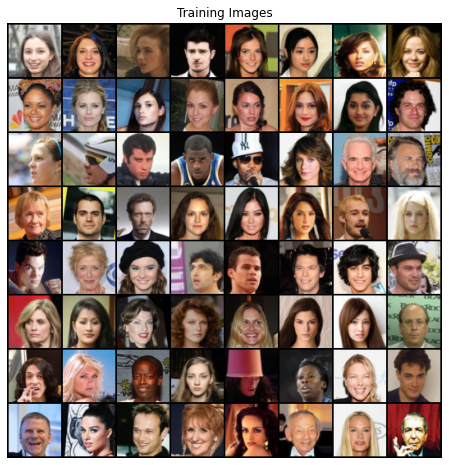

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight Initialization

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') !=   -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### The DCGAN Generator
The archetecture of the generator is as follows:
![](./dcgan_generator.png)

This generator is composed of 5 transposed convolutional layers. After each convolutional layer, the output size will be enlarged.

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, x):
        return self.main(x)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### The DCGAN Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Loss function

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

### Optimizers

The generator and the discriminator each get their own optimizers.

In [12]:
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))